#metaBEAT analysis of Illumina MiSeq output for Lake project_12S_Feb_2017

Mark sure your metaBEAT image version is the latest

`metaBEAT - metaBarcoding and Environmental DNA Analyses tool version: v.0.97.9-global`

Update from your terminal

####check the image, the latest ID should be f2646ec2d352

sudo docker images
####if not, use the command to update the image from your terminal

sudo docker pull chrishah/metabeat


###The first step will be to demultiplex and trim/clean our raw Illumina data

Prepare a text file `Querymap` specifying the samples to be processed including the format and location of the reads.

The __raw data__ need to be downloaded with `How_to_download_Rawdata_from_SRA.ipynb` (see [here](https://github.com/HullUni-bioinformatics/Li_et_al_2018_eDNA_fish_monitoring/blob/master/12S/How_to_download_Rawdata_from_SRA.ipynb))


We need a __query map__ (see [here](https://github.com/HullUni-bioinformatics/Li_et_al_2018_eDNA_fish_monitoring/blob/master/12S/Querymap_demultiplex_trimming_12S.txt) which lists these files along with the primer combinations for each well in each file, and the length of the primer sequence (including heterogeneity spacers, but NOT including any tags) to be trimmed off.


In [1]:
!pwd

/home/working


In [2]:
!mkdir trimming

In [3]:
cd trimming/

/home/working/trimming


In [4]:
!mv ../Querymap_demultiplex_trimming_12S.txt ../trimming/

In [5]:
!head Querymap_demultiplex_trimming_12S.txt

BET01	fastq	../raw_data/BET-12S_R1.fastq.gz	../raw_data/BET-12S_R2.fastq.gz	TCGCCTTA	TAGATCGC	18	18
BET02	fastq	../raw_data/BET-12S_R1.fastq.gz	../raw_data/BET-12S_R2.fastq.gz	TCGCCTTA	CTCTCTAT	18	19
BET03	fastq	../raw_data/BET-12S_R1.fastq.gz	../raw_data/BET-12S_R2.fastq.gz	TCGCCTTA	TATCCTCT	18	20
BET04	fastq	../raw_data/BET-12S_R1.fastq.gz	../raw_data/BET-12S_R2.fastq.gz	TCGCCTTA	AGAGTAGA	18	21
BET05	fastq	../raw_data/BET-12S_R1.fastq.gz	../raw_data/BET-12S_R2.fastq.gz	TCGCCTTA	GTAAGGAG	18	22
BET06	fastq	../raw_data/BET-12S_R1.fastq.gz	../raw_data/BET-12S_R2.fastq.gz	TCGCCTTA	ACTGCATA	18	23
BET07	fastq	../raw_data/BET-12S_R1.fastq.gz	../raw_data/BET-12S_R2.fastq.gz	TCGCCTTA	AAGGAGTA	18	24
BET08	fastq	../raw_data/BET-12S_R1.fastq.gz	../raw_data/BET-12S_R2.fastq.gz	TCGCCTTA	CTAAGCCT	18	25
BET09	fastq	../raw_data/BET-12S_R1.fastq.gz	../raw_data/BET-12S_R2.fastq.gz	CTAGTACG	TAGATCGC	19	18
BET10	fastq	../raw_data/BET-12S_R1.fastq.gz	../raw_data/BET-12S_R2.fastq.gz	CTAGTACG	CTCTCTAT	19	19


In [6]:
ls ../raw_data/

BET-12S_R1.fastq.gz  LLB-12S_R1.fastq.gz  PAD-12S_R1.fastq.gz
BET-12S_R2.fastq.gz  LLB-12S_R2.fastq.gz  PAD-12S_R2.fastq.gz
CAM-12S_R1.fastq.gz  LLG-12S_R1.fastq.gz  PEN-12S_R1.fastq.gz
CAM-12S_R2.fastq.gz  LLG-12S_R2.fastq.gz  PEN-12S_R2.fastq.gz
CWE-12S_R1.fastq.gz  MAP-12S_R1.fastq.gz  TRA-12S_R1.fastq.gz
CWE-12S_R2.fastq.gz  MAP-12S_R2.fastq.gz  TRA-12S_R2.fastq.gz
FEN-12S_R1.fastq.gz  OGW-12S_R1.fastq.gz  WLF-12S_R1.fastq.gz
FEN-12S_R2.fastq.gz  OGW-12S_R2.fastq.gz  WLF-12S_R2.fastq.gz
KEN-12S_R1.fastq.gz  OSS-12S_R1.fastq.gz
KEN-12S_R2.fastq.gz  OSS-12S_R2.fastq.gz


###Raw data demultiplex and trimming, removal of adapter sequences and merging of reads using the metaBEAT pipeline.¶

__The manual of metaBEAT_global.py can run the command as below__

In [ ]:
%%bash

metaBEAT_global.py -h

Now we run the trimming and clustering; note that there is no assignment method selected at this stage so metaBEAT will not attempt to make any assignments

In [8]:
%%bash

echo -e "Starttime: $(date)\n"

metaBEAT_global.py \
-Q Querymap_demultiplex_trimming.txt \
--trim_qual 30 \
--trim_minlength 90 \
--merge \
--product_length 110 \
--read_crop 110 \
--forward_only \
--length_filter 100 \
--length_deviation 0.2 \
-n 5 -v \
-@ haikuilee@gmail.com &> log_trimming

echo -e "Endtime: $(date)\n"

Starttime: Thu Nov 30 20:03:33 UTC 2017

Endtime: Thu Nov 30 23:59:51 UTC 2017



__Query survival after trimming__

Some stats on the read counts before/after trimming, merging etc. are summarized for you in `metaBEAT_read_stats.csv`.

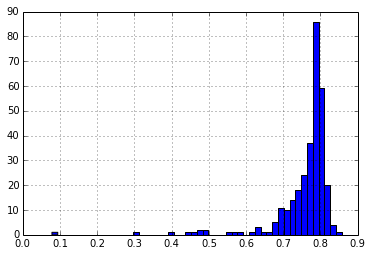

In [9]:
%matplotlib inline
import pandas as pd

df = pd.read_csv('metaBEAT_read_stats.csv',index_col=0)
df['fraction'] = df['queries']/(df['total']*0.5)
df.fraction.hist(bins=50)

In [13]:
cd ../

/home/working


###Next stage of the processing is chimera detection and removal of putative chimeric sequences

We'll do that using `uchime` as implemented in `vsearch`.

In [14]:
!mkdir chimera_detection

In [15]:
cd chimera_detection/

/home/working/chimera_detection


### Prepare Ref map
    
Convert reference database from Genbank to fasta format to be used in chimera detection.

Prepare Refmap file, i.e. text file that specifies the location and the format of the reference to be used.

The reference sequences in Genbank format should already be present in the `supplementary_data` directory: `12S_Fish_SATIVA_cleaned_May_2017.gb`
And `Astatotilapia_calliptera.gb` is positive control

In [16]:
!ls ../supplementary_data/reference_DBs/

12S_Fish_SATIVA_cleaned_May_2017.gb  Astatotilapia_calliptera.gb


In [17]:
%%bash

#Write REFmap
for file in $(ls -1 ../supplementary_data/reference_DBs/* | grep ".gb$")
do
      echo -e "$file\tgb"
done > REFmap.txt

In [18]:
!cat REFmap.txt

../supplementary_data/reference_DBs/12S_Fish_SATIVA_cleaned_May_2017.gb	gb
../supplementary_data/reference_DBs/Astatotilapia_calliptera.gb	gb


__Transfer reference DB from gb to fasta format__

This will produce `refs.fasta`

In [ ]:
%%bash

metaBEAT_global.py \
-R REFmap.txt \
-f \
-@ haikuilee@gmail.com

In [ ]:
!head -2 refs.fasta


__Now run chimera detection__

In [ ]:
%%bash

echo -e "Starttime: $(date)\n"

for a in $(cut -f 1 ../trimming/Querymap_demultiplex_trimming_12S.txt)
do
    if [ -s ../trimming/$a/$a\_trimmed.fasta ]
    then
        echo -e "\n### Detecting chimeras in $a ###\n"
        mkdir $a
        cd $a
        vsearch --uchime_ref ../../trimming/$a/$a\_trimmed.fasta --db ../refs.fasta \
        --nonchimeras $a-nonchimeras.fasta --chimeras $a-chimeras.fasta &> log
        cd ..

    else
        echo -e "$a is empty"
    fi
done

echo -e "Endtime: $(date)\n"

### Last step is taxonomic assignment of reads based on a BLAST - LCA approach using the metaBEAT pipeline.

In [23]:
cd ..

/home/working


In [24]:
!mkdir non-chimeras

In [25]:
cd non-chimeras/

/home/working/non-chimeras


__Prepare Querymap and Refmap txt files__

__To skip the `GLOBAL` folder under chimeras detection, add a new line in below command  if [ "$a" != "GLOBAL" ]__

In [26]:
%%bash

#Querymap
for a in $(ls -l ../chimera_detection/ | grep "^d" | perl -ne 'chomp; @a=split(" "); print "$a[-1]\n"')
do
   if [ "$a" != "GLOBAL" ]
   then
      echo -e "$a-nc\tfasta\t../chimera_detection/$a/$a-nonchimeras.fasta"
   fi
done > Querymap.txt


#Write REFmap
for file in $(ls -1 ../supplementary_data/reference_DBs/* | grep ".gb$")
do
      echo -e "$file\tgb"
done > REFmap.txt

In [ ]:
!head -10  Querymap.txt

In [28]:
!cat REFmap.txt

../supplementary_data/reference_DBs/12S_Fish_SATIVA_cleaned_May_2017.gb	gb
../supplementary_data/reference_DBs/Astatotilapia_calliptera.gb	gb


__Sequence clustering and taxonomic assignment via metaBEAT__

In [29]:
%%bash

echo -e "Starttime: $(date)\n"

metaBEAT_global.py \
-Q Querymap.txt \
-R REFmap.txt \
--blast --min_ident 1.0 \
--cluster --clust_match 1 --clust_cov 3 \
-m 12S -n 5 \
-E -v \
-@  haikuilee@gmail.com \
-o 12S_LP-trim_30-merged-nonchimeras-cluster_1c3-blast-min_ident_1 &> log_non-chimeras

echo -e "Endtime: $(date)\n"

Starttime: Fri Dec  1 19:28:27 UTC 2017

Endtime: Fri Dec  1 19:42:41 UTC 2017



__Results are under the `GLOBAL` folder__